2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
Epoch 0/100 | D Loss: 1.2671725749969482 | G Loss: 1.0590273141860962
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 10/100 | D Loss: 1.3438870906829834 | G Loss: 1.3608978986740112
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Epoch 20/100 | D Loss

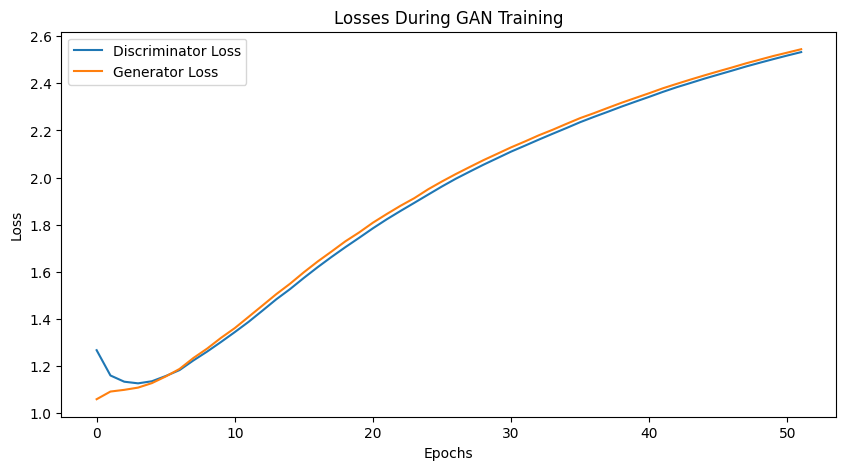

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

# Define the generator network
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(784, activation='tanh'))
    model.add(Reshape((28, 28, 1)))
    return model

# Define the discriminator network
def build_discriminator():
    model = Sequential()
    model.add(Flatten(input_shape=(28, 28, 1)))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# Build and compile the discriminator
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# Build the generator
generator = build_generator()

# The generator takes noise as input and generates images
z = Input(shape=(100,))
img = generator(z)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(img)

# The combined model (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, validity)
combined.compile(loss='binary_crossentropy', optimizer=Adam())

# Load MNIST dataset
(X_train, _), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train / 127.5 - 1.  # Rescale the images to the range [-1, 1]
X_train = np.expand_dims(X_train, axis=3)  # Add channel dimension

# Training parameters
epochs = 100  # Reduced epochs for faster testing
batch_size = 64  # Increased batch size for faster training
sample_interval = 500  # Save generated images every 500 epochs

# List to track losses
d_losses = []  # Discriminator losses
g_losses = []  # Generator losses

# Training loop
for epoch in range(epochs):
    # Train discriminator
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    noise = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(noise)

    # Train on real and fake images
    d_loss_real = discriminator.train_on_batch(imgs, np.ones((batch_size, 1)))  # Real images
    d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((batch_size, 1)))  # Fake images
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    noise = np.random.normal(0, 1, (batch_size, 100))
    g_loss = combined.train_on_batch(noise, np.ones((batch_size, 1)))  # The generator tries to fool the discriminator

    # Append the losses to the respective lists
    d_losses.append(d_loss[0])
    g_losses.append(g_loss[0])

    # Print losses at every 10th epoch
    if epoch % 10 == 0:
        print(f"Epoch {epoch}/{epochs} | D Loss: {d_loss[0]} | G Loss: {g_loss[0]}")

    # Save generated images at specified intervals
    if epoch % sample_interval == 0:
        noise = np.random.normal(0, 1, (25, 100))  # Generate 25 images
        gen_imgs = generator.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5  # Rescale to [0, 1]

        # Plot and save the generated images
        fig, axs = plt.subplots(5, 5)
        cnt = 0
        for i in range(5):
            for j in range(5):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.savefig(f"gan_generated_image_epoch_{epoch}.png")
        plt.close()  # Close the plot to save memory

    # Early stopping condition: If the generator loss doesn't improve
    if epoch > 50 and g_loss[0] > 0.5:  # Access the loss from the list
        print(f"Early stopping at epoch {epoch} as the generator loss hasn't improved.")
        break

# After training, plot the losses
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('Losses During GAN Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
